In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm
from pm4py.visualization.process_tree import visualizer as pt_vis
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_vis_factory


from pm4py.algo.filtering.log.cases import case_filter


from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive.variants import im

from pm4py.objects.conversion.process_tree import converter as pt_converter

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

In [53]:
# Load CSV
df = pd.read_csv("../data/Purchasing-Example.csv")

# Rename columns to match PM4Py expectations
df.rename(columns={
    "Case ID": "case:concept:name",
    "Activity": "concept:name",
    "Complete Timestamp": "time:timestamp"
}, inplace=True)

# Convert timestamp column to datetime
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])

# Standardize dataframe for PM4Py
df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Convert to Event Log
log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

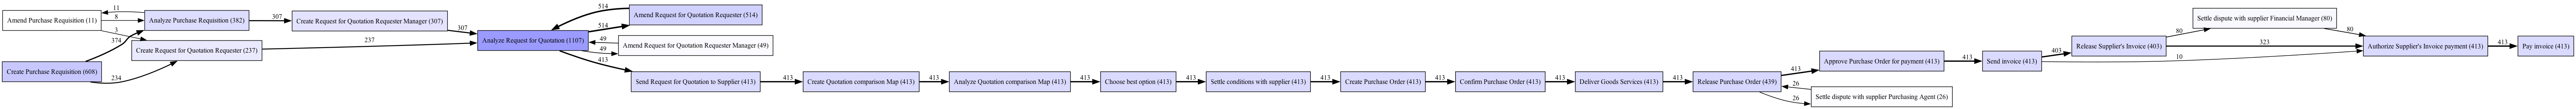

In [54]:
dfg = dfg_algorithm.apply(log)

gviz = dfg_vis_factory.apply(dfg, log=log)
dfg_vis_factory.view(gviz)
# dfg_vis_factory.save(gviz, "my_dfg.png")

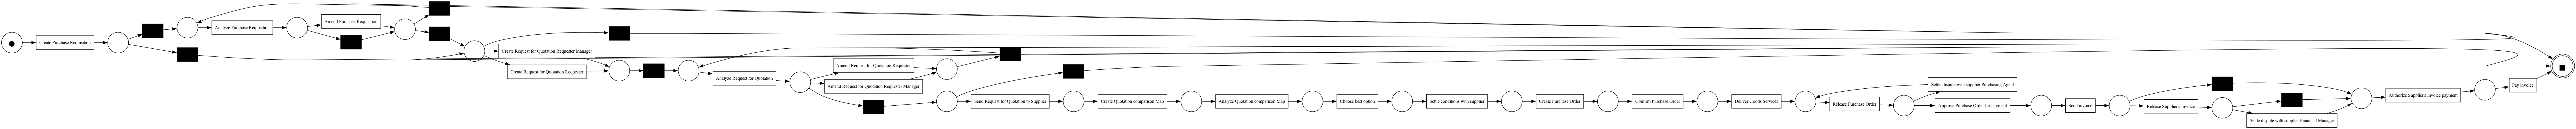

In [56]:
tree = inductive_miner.apply(log, variant=inductive_miner.Variants.IM)

net, initial_marking, final_marking = pt_converter.apply(tree)

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
# pn_visualizer.save(gviz, "my_petri_net.png")

In [60]:
# replay_result contain?
# - list of dictionaries, 
# - 1 dictionary per case/trace in event log, each containing like:
#     trace_fitness: How well the trace fits the model (between 0 and 1, where 1 is perfect fit)
#     tokens_consumed: Number of tokens consumed during replay
#     tokens_produced: Number of tokens produced
#     missing_tokens: Tokens that were expected by the model but missing in the log (indicates deviations)
#     remaining_tokens: Tokens left in the model after replay (also indicates deviations)
replay_result = token_replay.apply(log, net, initial_marking, final_marking)
print(replay_result)

replaying log with TBR, completed traces ::   0%|          | 0/98 [00:00<?, ?it/s]

[{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [(169f2356-540a-40e2-bb2c-8d57ea364a19, 'Create Purchase Requisition'), (init_loop_2, None), (fc68fb33-678f-466c-b4f3-c56dd5794d20, 'Analyze Purchase Requisition'), (a463b299-762e-4770-ba52-ee6178029804, 'Amend Purchase Requisition'), (skip_5, None), (fc68fb33-678f-466c-b4f3-c56dd5794d20, 'Analyze Purchase Requisition'), (skip_4, None), (skip_6, None), (c8975a25-d70b-42fe-a4eb-76891c03f514, 'Create Request for Quotation Requester Manager'), (init_loop_8, None), (6ce67b91-b998-4bdd-93fe-b383ad295414, 'Analyze Request for Quotation'), (249efdcd-b068-4afa-aa6c-dd51cc387130, 'Amend Request for Quotation Requester'), (loop_9, None), (6ce67b91-b998-4bdd-93fe-b383ad295414, 'Analyze Request for Quotation'), (skip_10, None), (skip_11, None)], 'reached_marking': ['sink:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 17, 'remaining_tokens': 0, 'produced_tok

In [61]:
replay_result[0]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(169f2356-540a-40e2-bb2c-8d57ea364a19, 'Create Purchase Requisition'),
  (init_loop_2, None),
  (fc68fb33-678f-466c-b4f3-c56dd5794d20, 'Analyze Purchase Requisition'),
  (a463b299-762e-4770-ba52-ee6178029804, 'Amend Purchase Requisition'),
  (skip_5, None),
  (fc68fb33-678f-466c-b4f3-c56dd5794d20, 'Analyze Purchase Requisition'),
  (skip_4, None),
  (skip_6, None),
  (c8975a25-d70b-42fe-a4eb-76891c03f514, 'Create Request for Quotation Requester Manager'),
  (init_loop_8, None),
  (6ce67b91-b998-4bdd-93fe-b383ad295414, 'Analyze Request for Quotation'),
  (249efdcd-b068-4afa-aa6c-dd51cc387130, 'Amend Request for Quotation Requester'),
  (loop_9, None),
  (6ce67b91-b998-4bdd-93fe-b383ad295414, 'Analyze Request for Quotation'),
  (skip_10, None),
  (skip_11, None)],
 'reached_marking': ['sink:1'],
 'enabled_transitions_in_marking': set(),
 'transitions_with_problems': [],
 'missing_tokens': 0,
 'consumed_tokens': 17,


In [65]:
# Trace fitness = How well events in trace can be replayed on the model without errors like:
#     Missing tokens (needed to fire a transition, but not available)
#     Remaining tokens (model expects more steps, but trace ends)
#     Transitions in the model that should occur but don't (model mismatch)

case_ids = [trace.attributes['concept:name'] for trace in log]
fitness_scores = [result['trace_fitness'] for result in replay_result]

print("Conformance Fitness Report:")
for case_id, fitness in zip(case_ids, fitness_scores):
    print(f"Case {case_id}: Fitness = {fitness:.2f}")

average_fitness = sum(fitness_scores) / len(fitness_scores)
print(f"\nAverage Fitness over all cases: {average_fitness:.2f}")

Conformance Fitness Report:
Case 339: Fitness = 1.00
Case 940: Fitness = 1.00
Case 1417: Fitness = 1.00
Case 159: Fitness = 1.00
Case 330: Fitness = 1.00
Case 158: Fitness = 1.00
Case 949: Fitness = 1.00
Case 157: Fitness = 1.00
Case 156: Fitness = 1.00
Case 1310: Fitness = 1.00

Average Fitness over all cases: 1.00


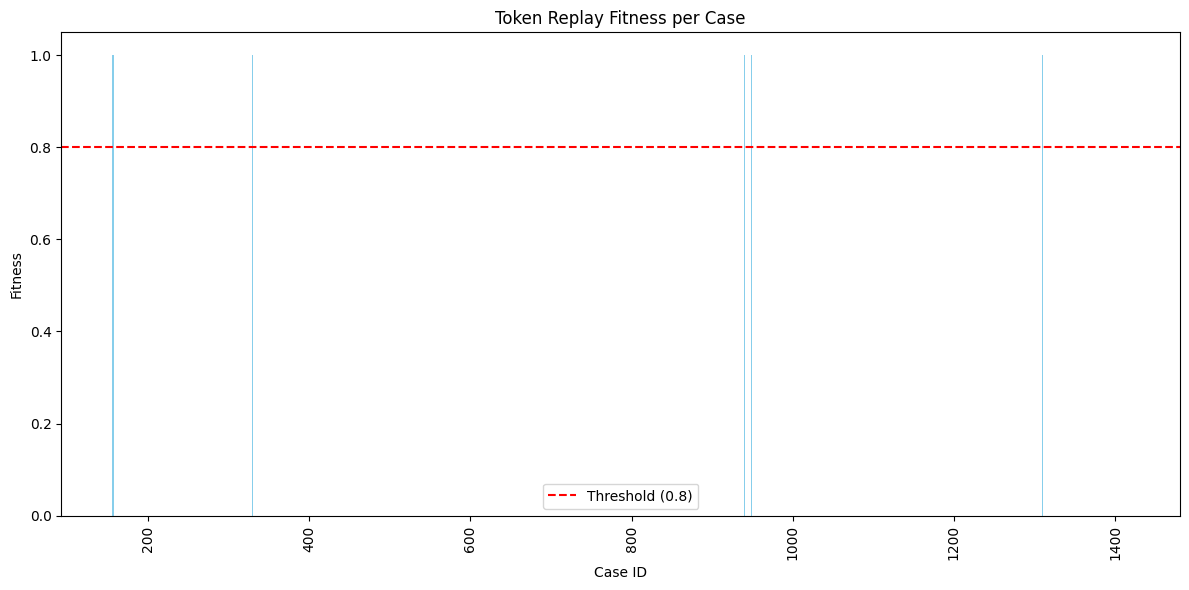

In [66]:
plt.figure(figsize=(12, 6))
plt.bar(case_ids, fitness_scores, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Case ID')
plt.ylabel('Fitness')
plt.title('Token Replay Fitness per Case')
plt.ylim(0, 1.05)  # fitness ranges from 0 to 1
plt.axhline(y=0.8, color='r', linestyle='--', label='Threshold (0.8)')
plt.legend()
plt.tight_layout()
plt.show()


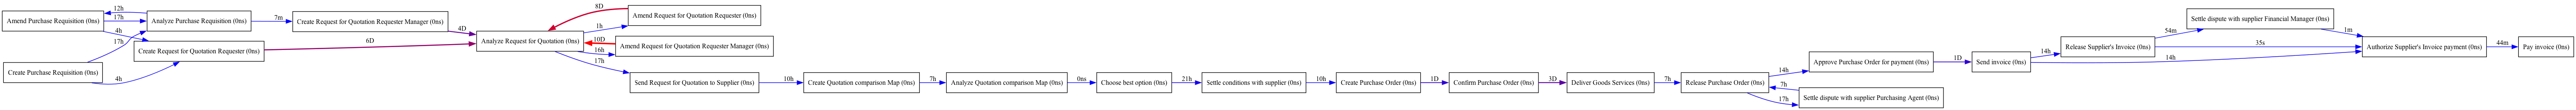

In [20]:
# performance-annotated DFG
#    edges show average/aggregate time taken between activities instead of just counts
dfg_performance = dfg_algorithm.apply(log, variant=dfg_algorithm.Variants.PERFORMANCE)
gviz_perf = dfg_vis_factory.apply(dfg_performance, log=log, variant=dfg_vis_factory.Variants.PERFORMANCE)
dfg_vis_factory.view(gviz_perf)
# dfg_vis_factory.save(gviz_perf, "performance_dfg.png")

     Case ID  Duration (seconds)
0        339           1012260.0
1        940            983460.0
2       1417           1349520.0
3        159           1291260.0
4        330            496380.0
..       ...                 ...
603      906           7582440.0
604     1161           8694180.0
605      259            895680.0
606      254           1017480.0
607     1358           7689300.0

[608 rows x 2 columns]


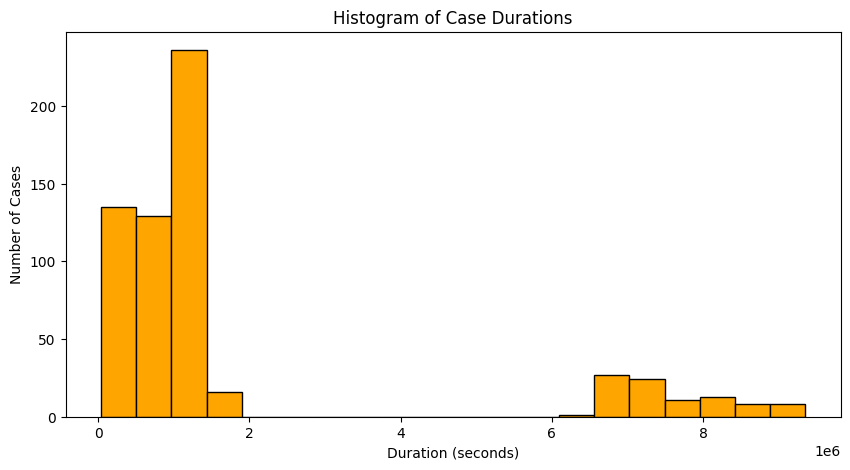

In [21]:
# Calculate total case durations
case_durations = []
for trace in log:
    start = trace[0]["time:timestamp"]
    end = trace[-1]["time:timestamp"]
    case_durations.append((trace.attributes['concept:name'], (end - start).total_seconds()))

# Convert to DataFrame for convenience
case_duration_df = pd.DataFrame(case_durations, columns=["Case ID", "Duration (seconds)"])

print(case_duration_df)

# Plot histogram of case durations
plt.figure(figsize=(10, 5))
plt.hist(case_duration_df["Duration (seconds)"], bins=20, color='orange', edgecolor='black')
plt.title("Histogram of Case Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Cases")
plt.show()


In [22]:
activity_durations = {}

for trace in log:
    for i in range(1, len(trace)):
        prev_event = trace[i-1]
        curr_event = trace[i]
        activity = curr_event["concept:name"]
        duration = (curr_event["time:timestamp"] - prev_event["time:timestamp"]).total_seconds()
        if activity not in activity_durations:
            activity_durations[activity] = []
        activity_durations[activity].append(duration)

# average duration per activity
avg_activity_durations = {act: np.mean(durs) for act, durs in activity_durations.items()}

print("Average Activity Durations (seconds):")
for act, avg_dur in avg_activity_durations.items():
    print(f"{act}: {avg_dur:.2f}")


Average Activity Durations (seconds):
Analyze Purchase Requisition: 62220.79
Amend Purchase Requisition: 43985.45
Create Request for Quotation Requester Manager: 448.53
Analyze Request for Quotation: 599394.20
Amend Request for Quotation Requester: 3605.02
Create Request for Quotation Requester: 15291.14
Send Request for Quotation to Supplier: 61747.99
Create Quotation comparison Map: 39181.60
Analyze Quotation comparison Map: 25255.50
Choose best option: 0.00
Settle conditions with supplier: 75774.77
Create Purchase Order: 37491.72
Confirm Purchase Order: 156506.88
Deliver Goods Services: 334992.20
Release Purchase Order: 27450.34
Approve Purchase Order for payment: 52835.30
Send invoice: 168786.54
Authorize Supplier's Invoice payment: 1294.43
Pay invoice: 2672.54
Release Supplier's Invoice: 51907.59
Settle dispute with supplier Financial Manager: 3256.50
Settle dispute with supplier Purchasing Agent: 61470.00
Amend Request for Quotation Requester Manager: 58727.76


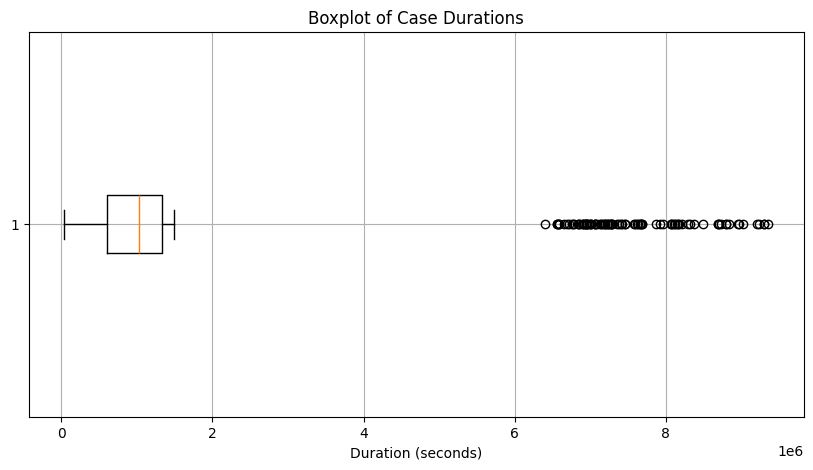

In [23]:
plt.figure(figsize=(10, 5))
plt.boxplot(case_duration_df["Duration (seconds)"], vert=False)
plt.title("Boxplot of Case Durations")
plt.xlabel("Duration (seconds)")
plt.grid(True)
plt.show()

In [24]:



# Calculate IQR(Interquartile Range)
Q1 = case_duration_df["Duration (seconds)"].quantile(0.25) #Value below which 25% of cases fall
Q3 = case_duration_df["Duration (seconds)"].quantile(0.75) #Value below which 75% of cases fall
IQR = Q3 - Q1 # middle 50% of durations


# https://en.wikipedia.org/wiki/Interquartile_range#Outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = case_duration_df[
    (case_duration_df["Duration (seconds)"] < lower_bound) |
    (case_duration_df["Duration (seconds)"] > upper_bound)
]

print(f"Found {len(outliers)} outlier cases.")
display(outliers.sort_values("Duration (seconds)", ascending=False))


Found 92 outlier cases.


,Case ID,Duration (seconds)
319,655,9355380.0
602,1160,9303900.0
279,892,9292500.0
565,1025,9228240.0
300,635,9199260.0
...,...,...
431,1299,6580620.0
555,1141,6566160.0
281,690,6564900.0
472,1375,6563700.0
